# Data Loading and Cleaning

In [3]:
# Accumulate data in dataframes only if it satisfies certain criteria as per explanation in design document.
# Invalid fields and unused/unimportant values are filtered out at the time of loading.

import gzip
import json
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,}'.format
%matplotlib inline

import dateutil.parser as dparser

DIR = './dataset'

YEAR_FILTER = 2016

column_not_needed_to_be_in_frame = ['is_read','read_at']

my_columns = ['user_id', 'book_id', 'rating', 'date_updated']

from itertools import islice

# Use itertools islice to iterate
def iterate_with_slice(file_name, start=0, end=10):
    iter_data = []
    count = -1
    with gzip.open(file_name) as fin:
        chunked_file = islice(fin, start, end, None)
        for line in chunked_file:
            d = json.loads(line)
            count = count + 1
            if (not d['is_read'] or d['is_read'] is False):
                continue
            if (not d['date_updated'] or not d['read_at']):
                continue
            if (not d['user_id'] or not d['book_id'] or not d['rating']):
                continue
            year = dparser.parse(d['date_updated'],fuzzy=True).year
            if year != YEAR_FILTER:
                continue
            iter_data.append(pd.DataFrame({'user_id': d['user_id'],
                                            'book_id': d['book_id'],
                                            'rating': d['rating'],
                                            'date_updated': d['date_updated']},
                                           index=[count]))
    return iter_data


## Dataframes composition over iterations 

In [15]:
iter_1 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=0, end=10000)
df_iter_1 = pd.concat(iter_1, ignore_index=True)
print(df_iter_1.shape)

(938547, 4)


In [ ]:
iter_2 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=10000, end=50000)
df_iter_2 = pd.concat(iter_2, ignore_index=True)
print(df_iter_2.shape)

In [ ]:
iter_3 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=50000, end=100000)
df_iter_3 = pd.concat(iter_3, ignore_index=True)
print(df_iter_3.shape)

In [ ]:
iter_4 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=100000, end=500000)
df_iter_4 = pd.concat(iter_4, ignore_index=True)
print(df_iter_4.shape)

In [ ]:
iter_5 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=500000, end=1000000)
df_iter_5 = pd.concat(iter_5, ignore_index=True)
print(df_iter_5.shape)

In [ ]:
iter_6 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=1000000, end=5000000)
df_iter_6 = pd.concat(iter_6, ignore_index=True)
print(df_iter_6.shape)

In [ ]:
iter_7 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=5000000, end=20000000)
df_iter_7 = pd.concat(iter_7, ignore_index=True)
print(df_iter_7.shape)

In [ ]:
iter_8 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=20000000, end=40000000)
df_iter_8 = pd.concat(iter_8, ignore_index=True)
print(df_iter_8.shape)

In [ ]:
iter_9 = iterate_with_slice(os.path.join(DIR, 'goodreads_interactions_fantasy_paranormal.json.gz'), start=40000000, end=55397551)
df_iter_9 = pd.concat(iter_9, ignore_index=True)
print(df_iter_9.shape)


## Install relevant modules

In [17]:
!pip install tensorflow
!pip install keras
import tensorflow as tf
tf.__version__

'2.0.0'

In [59]:
# With various dataframes initialized, compose a list from Python's locals() to concatenate into a combined dataset
dataset_list = []
dataset_list.extend(value for name, value in locals().items() if name.startswith('df_iter_'))
combined_dataset = pd.concat(dataset_list, ignore_index=True)
print(combined_dataset.shape)

# Convert user_id strings to integer mappings for embedding representations
user_id_cat = combined_dataset.user_id.astype('category').cat
codes_user_id = user_id_cat.codes
cats_user_id = user_id_cat.categories

# Convert book_id strings to integer mappings for embedding representations
book_id_cat = combined_dataset.book_id.astype('category').cat
codes_book_id = book_id_cat.codes
cats_book_id = book_id_cat.categories

# Full Dataset now contains the user_id and book_id fields in integer form making embeddings easier to learn patterns 
full_dataset = pd.DataFrame(columns=['user_id', 'book_id', 'rating', 'date_updated'])
full_dataset['user_id'] = codes_user_id.values
full_dataset['book_id'] = codes_book_id.values
full_dataset['rating'] = combined_dataset.rating
full_dataset['date_updated'] = combined_dataset.date_updated

n_users_total = len(full_dataset.user_id.unique())
print(n_users_total)

n_books_total = len(full_dataset.book_id.unique())
print(n_books_total)

# Training dataset comprises data from 11 months of 2016.
# Timestamp column can be dropped after apportioning the dataset.
train_dataset = full_dataset[~full_dataset['date_updated'].str.contains("Dec", regex=False)]
train_dataset = train_dataset.drop('date_updated', 1)
print(train_dataset.head())

# Test dataset comprises data from December of 2016.
# Timestamp column can be dropped after apportioning the dataset.
test_dataset = full_dataset[full_dataset['date_updated'].str.contains("Dec", regex=False)]
test_dataset = test_dataset.drop('date_updated', 1)
print(test_dataset.head())

(2151774, 4)
214213
144899
   user_id  book_id  rating
1   113959     3173       5
3    97831    99512       2
4    97831   139736       3
5    97831   128024       4
6    97831   119470       4
    user_id  book_id  rating
0    113959    99437       3
2    113959   132565       5
26     1591   108828       5
30    63155   116539       4
42   147009    40803       5


In [61]:
# Split the transformed dataset into train-validation splits with ratio 80:20 
from sklearn.model_selection import train_test_split

%matplotlib inline
new_train, new_validation = train_test_split(train_dataset, test_size=0.2, random_state=42)

# Creating Neural Network Model

Neural Network approach with embedding and Fully-Connected layers for user-book pattern recommendation system.

In [62]:
from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from keras.models import Model

n_latent_factors_book = 5
n_latent_factors_user = 5

# Create book embedding vector
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books_total + 1, n_latent_factors_book, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# Create user embedding vector
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users_total + 1, n_latent_factors_user, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# Concatenate features
conc = Concatenate()([book_vec, user_vec])

# Add Fully-Connected layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# For a simple matrix factorization/embedding design, one could perform dot product of the input features.
# The accuracies weren't high enough, hence decided to go with a NN model
# prod = Dot(name="Dot-Product", axes=1)([book_vec, user_vec])
# model = Model([user_input, book_input], prod)
# model.compile('adam', 'mean_squared_error')

# Create a more complex NN model
model2 = Model([user_input, book_input], out)
model2.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
1564773/1564773 [==============================] - 1712s 1ms/step - loss: 0.7158 - mean_squared_error: 0.7158
Epoch 2/5
1564773/1564773 [==============================] - 1743s 1ms/step - loss: 0.5944 - mean_squared_error: 0.5944
Epoch 3/5
1564773/1564773 [==============================] - 1328s 849us/step - loss: 0.5533 - mean_squared_error: 0.5533
Epoch 4/5
1564773/1564773 [==============================] - 1401s 896us/step - loss: 0.5196 - mean_squared_error: 0.5196
Epoch 5/5
1564773/1564773 [==============================] - 1769s 1ms/step - loss: 0.4897 - mean_squared_error: 0.4897


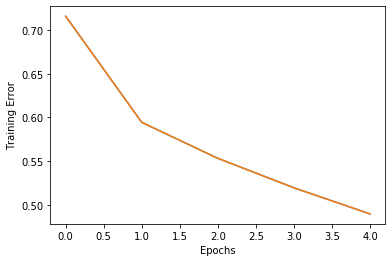

In [63]:
# Train the Model with training data
from keras.models import load_model

if os.path.exists('nn_model.h5'):
    model2 = load_model('nn_model.h5')
else:
    history = model2.fit([new_train.user_id, new_train.book_id], new_train.rating, epochs=5, verbose=1)
    model2.save('nn_model.h5')
    plt.plot(history.history['loss'])
    plt.plot(history.history['mean_squared_error'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

## Evaluation of Neural Network with Validation set

With the MSE training error above falling less than 0.5, we could check our validation set as we're concerned with a boolean( positive/negative) approach towards recommending a book (rating>=4 for positive recommendation). 

In [64]:
# Evaluate the Model on the Validation Set
model2.evaluate([new_validation.user_id, new_validation.book_id], new_validation.rating)

391194/391194 [==============================] - 13s 34us/step


[0.6521938849860804, 0.6521934866905212]

In [72]:
print(model2.metrics_names)

['loss', 'mean_squared_error']


We note that the Loss and MSE on the validation set is ~0.65 on the rating. This gives room for tweaking our network to reduce the errors. Possible approaches are 
* More epochs.
* More hidden layers.

For now, we continue to evaluate our test set since we're concerned with binary recommendations (positive or negative) past a certain threshold (rating >=4). With absolute rating predictions, we'd want to drive this down further for sure.

In [65]:
# Predictions on the apportioned validation set.
predictions2 = model2.predict([new_validation.user_id.head(10), new_validation.book_id.head(10)])
[print(predictions2[i], new_validation.rating.iloc[i]) for i in range(0,10)]

[4.7330337] 5
[3.419229] 4
[3.9431734] 3
[3.9313426] 4
[4.8205347] 3
[3.8971963] 5
[4.5720267] 4
[4.5786037] 5
[4.0088034] 4
[4.54173] 5


[None, None, None, None, None, None, None, None, None, None]

## Prediction on Test Dataset
### Predictions on the test set from December 2016
Illustrated with outputs in code cells below for a sample on first 10 items.
Please change this to any value desired feasible for inspection.

### Model output predictions and recommendations
```y_hat``` contains the rating predictions rounded up.

```y_hat_boolean``` contains the positive(1)/negative(0) recommendation for test (user_id, book_id) as per problem statement

In [71]:
predictions3 = model2.predict([test_dataset.user_id.head(10), test_dataset.book_id.head(10)])
[print(predictions3[i], test_dataset.rating.iloc[i]) for i in range(0,10)]

# Rounding up predictions
y_hat = np.round(predictions3, 0)
[print(y_hat[i], test_dataset.rating.iloc[i]) for i in range(0,10)]

# Boolean predictions to indicate positive(1) or negative(0) reviews based on thresholding at rating 4.
y_hat_boolean = np.where(y_hat >= 4, 1, 0)
print(y_hat_boolean)

[4.4408674] 3
[4.6056805] 5
[4.4163465] 5
[4.1427145] 4
[4.016427] 5
[3.9570866] 5
[3.9810514] 4
[3.9399958] 4
[4.5146976] 5
[4.286291] 5
[4.] 3
[5.] 5
[4.] 5
[4.] 4
[4.] 5
[4.] 5
[4.] 4
[4.] 4
[5.] 5
[4.] 5
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
